#### Imports

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import seaborn as sns

#### Define `data_filepath`

In [2]:
data_filepath = pathlib.Path('churn.csv')
assert data_filepath.exists(), f'{data_filepath} does not exist'

### Data prep with `pandas`

In [3]:
%%time

df_pd = pd.read_csv(data_filepath)

df_pd['TotalCharges'] = pd.to_numeric(
    df_pd['TotalCharges'], 
    errors='coerce',
)

binary_columns = []
for col in df_pd.columns:
    unique_vals = df_pd[col].sort_values().unique().tolist()
    if unique_vals == ['No', 'Yes']:
        binary_columns.append(col)

for col in binary_columns:
    df_pd[col] = df_pd[col].map({'No': 0, 'Yes': 1})

columns_to_exclude = ['customerID']
for col in df_pd.columns:
    if col not in columns_to_exclude:
        if df_pd.dtypes.loc[col] == 'object':
            dummy_columns = pd.get_dummies(df_pd[col], prefix=col, drop_first=True).astype(int)
            df_pd = pd.concat([df_pd, dummy_columns], axis=1)
            df_pd = df_pd.drop(columns=[col])
df_pd.shape

CPU times: user 104 ms, sys: 3.57 ms, total: 107 ms
Wall time: 106 ms


(7043, 32)

### Data prep with `polars`

In [4]:
%%time

df_pl = pl.read_csv(data_filepath)

binary_columns = []
for col in df_pl.columns:
    unique_vals = df_pl.get_column(col).unique().sort().to_list()
    if unique_vals == ['No', 'Yes']:
        binary_columns.append(col)

df_pl = df_pl.with_columns(
    pl.col(binary_columns).map_dict({'No': 0, 'Yes': 1})
)

columns_to_exclude = ['customerID']
string_columns = []
for (col, dtype) in zip(df_pl.columns, df_pl.dtypes):
    if col not in columns_to_exclude:
        if dtype == pl.Utf8:
            string_columns.append(col)

df_pl = df_pl.to_dummies(string_columns, drop_first=True)
df_pl.shape

CPU times: user 50 ms, sys: 7.36 ms, total: 57.3 ms
Wall time: 27.2 ms


(7043, 32)

We will use a `pandas` DataFrame since it will work nicely with other libaries. The following block shows how to convert the `polars` DataFrame to `pandas`.

In [5]:
data = df_pl.to_pandas()

### Feature Selection

The following code block defines variables that include our *target* variable (the variable we will train a model to predict), columns to ignore, and the features we will use for the prediction task.

In [6]:
target = 'Churn'
columns_to_ignore = ['customerID']

features = [col for col in data.columns if col != target]
features = list(set(features) - set(columns_to_ignore))
features = sorted(features)

The following code block shows how we can use `seaborn` to inspect the correlation between variables.

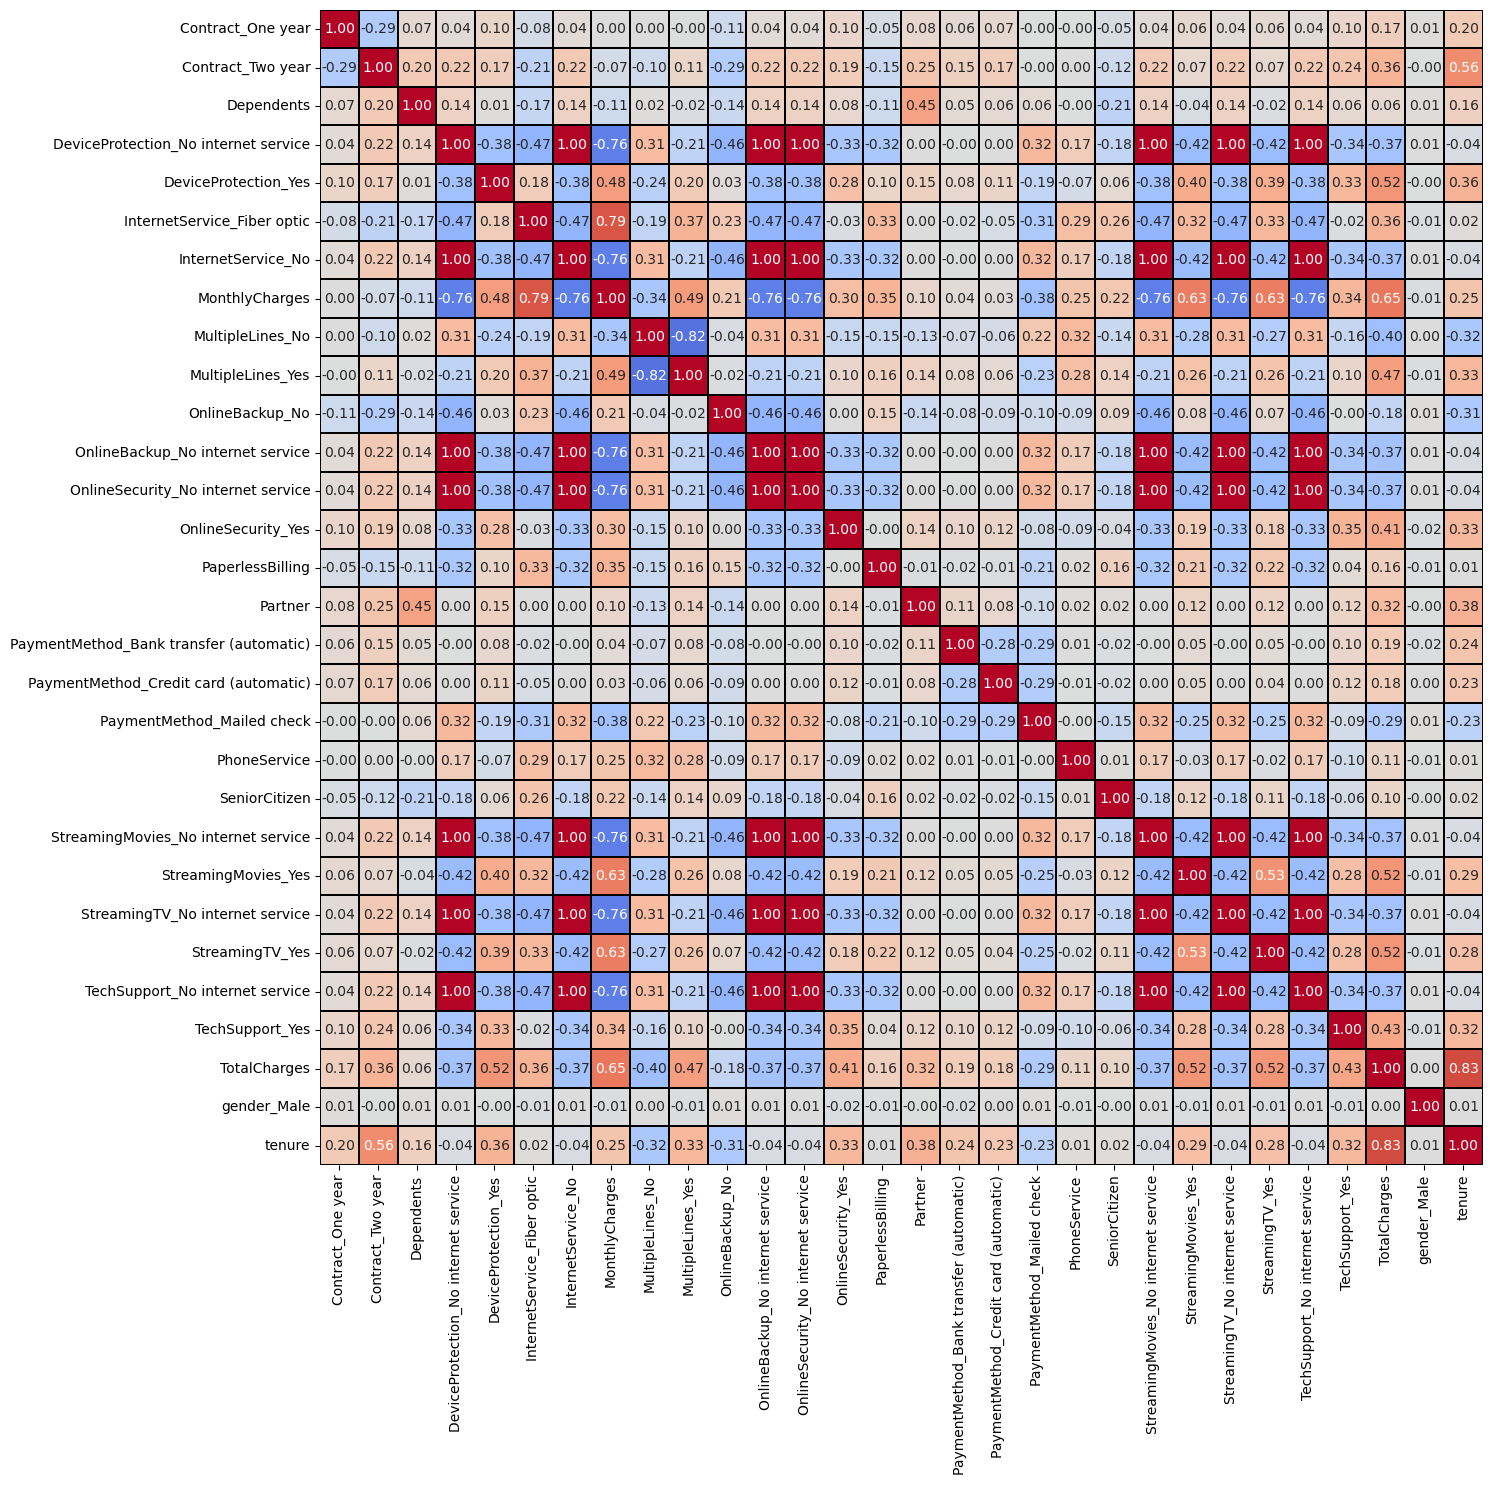

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

sns.heatmap(
    data[features].corr(),
    linewidths=0.1,
    linecolor='k',
    cmap='coolwarm',
    annot=True,
    fmt='0.2f',
    cbar=False,
    vmin=-1.0,
    vmax=1.0,
)

plt.show()

The following code block updates our `features` list to exclude any feature that includes the phrase "No internet service" and the feature "TotalCharges".

In [8]:
features_to_remove = [feature for feature in features if "No internet service" in feature]
features_to_remove += ['TotalCharges']
features = [feature for feature in features if feature not in features_to_remove]

The following code block generates the correlation plot for the updated feature list.

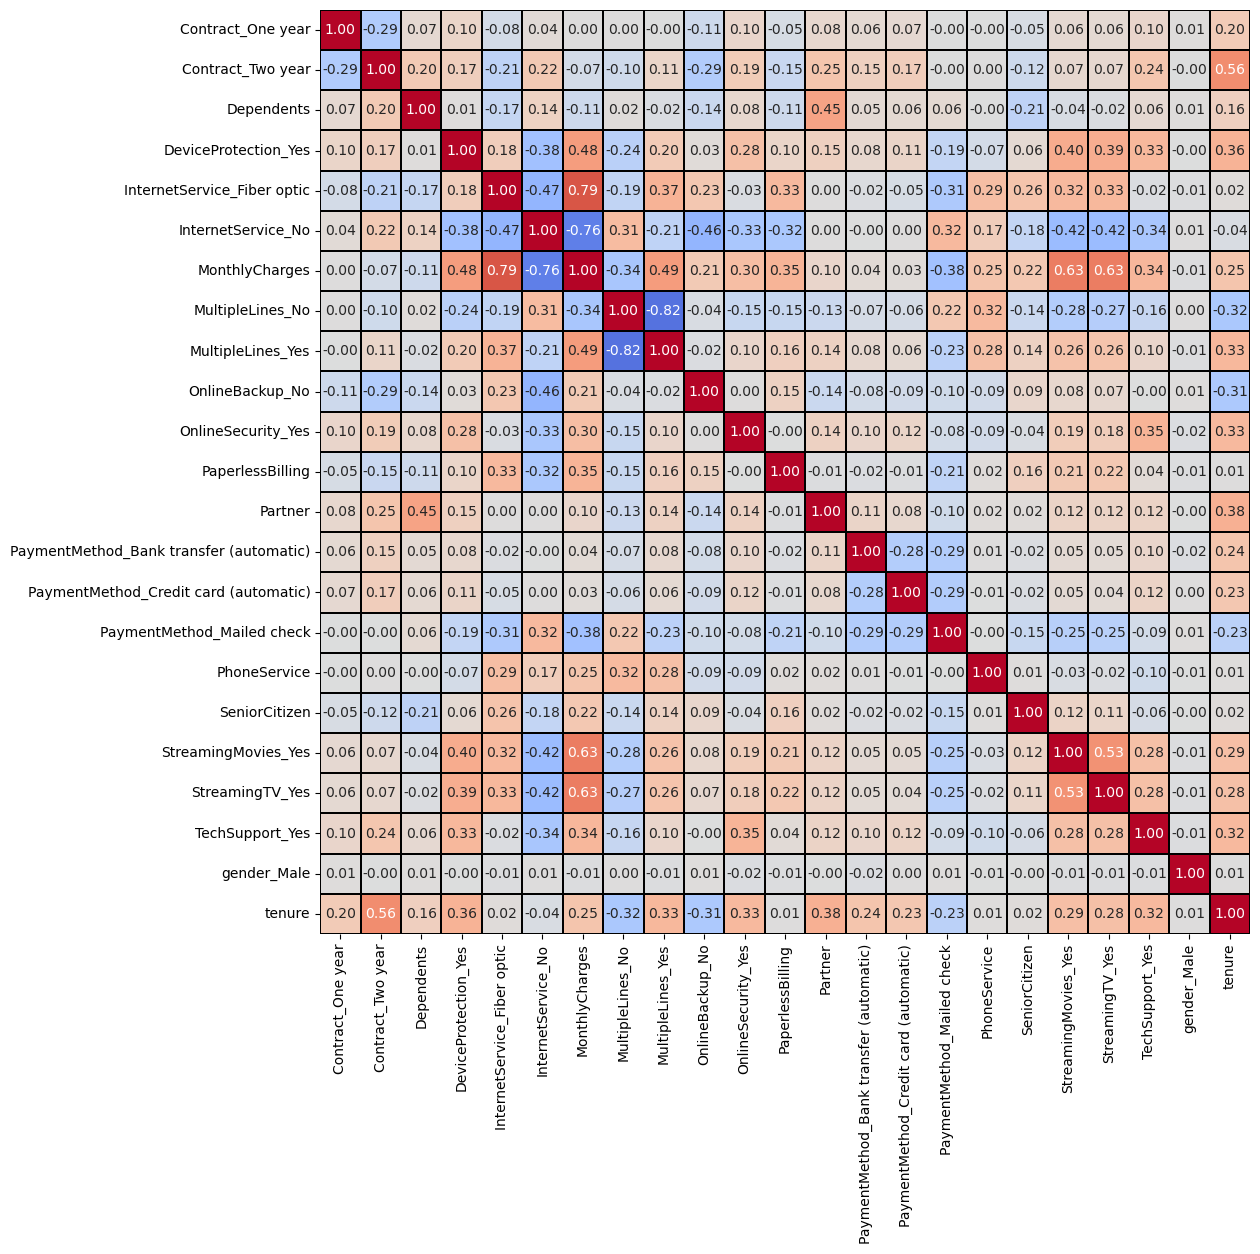

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.heatmap(
    data[features].corr(),
    linewidths=0.1,
    linecolor='k',
    cmap='coolwarm',
    annot=True,
    fmt='0.2f',
    cbar=False,
    vmin=-1.0,
    vmax=1.0,
)

plt.show()

### Predictive Modeling (V1)

The following code block shows the proportion of customers that do not churn is around 73.5%. Thus, when we are considering a predictive model, we should at least be able to achieve an accuracy that matches this (otherwise, we are better off just predicting that no one churns).

In [10]:
print(f'The proportion of customers that don\'t churn is {len(data[data["Churn"]==0])/len(data):.4}.')

The proportion of customers that don't churn is 0.7346.


To mimic the style used in the `scikit-learn` documentation, we create `X` and `y` datasets and then use the `train_test_split` function to create training and testing datasets. Note that we specify that the `y` dataset should be used to straify the created datasets. This ensures that the proportion of the two classes is as close as possible in the created datasets.

In [11]:
X = data[features].copy()
y = data[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    stratify=y, 
    random_state=42,
)

The following code block fits a decision tree classifier using the default hyperparamter settings. The decision tree overfits, which is evidenced by the significant difference in performance on the training and testing sets. We would say that this model does not generalize well.

In [12]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
training_set_score = clf.score(X_train, y_train)
testing_set_score = clf.score(X_test, y_test)

print(f' - Training set score {training_set_score:.3}')
print(f' - Testing set score {testing_set_score:.3}')

 - Training set score 0.998
 - Testing set score 0.726


The following code block fits a decision tree classifier that limits the `max_depth` to 5. This avoids overfitting and results in a model that performs nearly as well on the testing data as the training data.

In [13]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)
training_set_score = clf.score(X_train, y_train)
testing_set_score = clf.score(X_test, y_test)

print(f' - Training set score {training_set_score:.3}')
print(f' - Testing set score {testing_set_score:.3}')

 - Training set score 0.798
 - Testing set score 0.784


The following code block shows the classification policy that is learned by the decision tree.

In [14]:
dt_logic = export_text(clf, feature_names=features)
print(dt_logic)

|--- tenure <= 10.50
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- OnlineBackup_No <= 0.50
|   |   |   |--- tenure <= 1.50
|   |   |   |   |--- SeniorCitizen <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SeniorCitizen >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- tenure >  1.50
|   |   |   |   |--- MonthlyCharges <= 25.80
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- MonthlyCharges >  25.80
|   |   |   |   |   |--- class: 0
|   |   |--- OnlineBackup_No >  0.50
|   |   |   |--- MonthlyCharges <= 55.40
|   |   |   |   |--- OnlineSecurity_Yes <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OnlineSecurity_Yes >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- MonthlyCharges >  55.40
|   |   |   |   |--- MonthlyCharges <= 65.65
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- MonthlyCharges >  65.65
|   |   |   |   |   |--- class: 0
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- tenure <= 1.50
|   |  

The following code block runs a simple experiment that shows the accuracy on the training and testing sets as the `max_depth` hyperparamter varies.

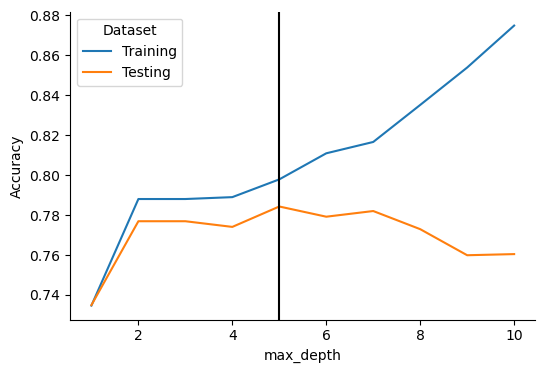

In [15]:
DT_experiment_vals = {}
for max_depth in range(1, 11):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    clf.fit(X_train, y_train)
    training_set_score = clf.score(X_train, y_train)
    testing_set_score = clf.score(X_test, y_test)
    DT_experiment_vals[max_depth] = {
        'Training': training_set_score,
        'Testing': testing_set_score,
    }
DT_experiment_vals = pd.DataFrame().from_dict(
    DT_experiment_vals, 
    orient='index',
)
DT_experiment_vals = DT_experiment_vals.reset_index()
DT_experiment_vals = DT_experiment_vals.rename(columns={'index': 'max_depth'})
DT_experiment_vals = DT_experiment_vals.melt(
    id_vars='max_depth',
    var_name='Dataset', 
    value_name='Accuracy',
)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(
    data=DT_experiment_vals,
    x='max_depth',
    y='Accuracy',
    hue='Dataset',
)
ax.axvline(5, color='k')
ax.spines[['top', 'right']].set_visible(False)
plt.show()